In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv('D3.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51766 entries, 0 to 51765
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      50750 non-null  object
 1   gender                    51766 non-null  object
 2   age                       51756 non-null  object
 3   admission_type_id         51766 non-null  int64 
 4   discharge_disposition_id  51766 non-null  int64 
 5   admission_source_id       51766 non-null  int64 
 6   time_in_hospital          51766 non-null  int64 
 7   medical_specialty         51766 non-null  object
 8   num_lab_procedures        51766 non-null  int64 
 9   num_procedures            51766 non-null  int64 
 10  num_medications           51766 non-null  int64 
 11  number_outpatient         51766 non-null  int64 
 12  number_emergency          51766 non-null  int64 
 13  number_inpatient          51766 non-null  int64 
 14  number_diagnoses      

In [2]:
from dm_tools import data_prep 
df,X,y,X_train, X_test, y_train, y_test = data_prep()

# Build a decision tree using the default setting

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

rs = 10
# simple decision tree training
model = DecisionTreeClassifier(random_state=rs)
model.fit(X_train, y_train)



DecisionTreeClassifier(random_state=10)

In [4]:
print("Train accuracy:", model.score(X_train, y_train))

Train accuracy: 1.0


In [5]:
print("Test accuracy:", model.score(X_test, y_test))

Test accuracy: 0.5714745653573728


In [6]:
n_nodes = model.tree_.node_count
print("The number of nodes are:")
print(n_nodes)

The number of nodes are:
19655


In [7]:
leaf = model.get_n_leaves()
print("The number of rules are:")
print(leaf)

The number of rules are:
9828


In [8]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.60      0.60      8382
           1       0.53      0.54      0.54      7148

    accuracy                           0.57     15530
   macro avg       0.57      0.57      0.57     15530
weighted avg       0.57      0.57      0.57     15530



In [9]:
import numpy as np

# grab feature importances from the model and feature name from the original X
importances = model.feature_importances_
feature_names = X.columns

# sort them out in descending order
indices = np.argsort(importances)
indices = np.flip(indices, axis=0)

# limit to 5 features, you can leave this out to print out everything
indices = indices[:5]

for i in indices:
    print(feature_names[i], ':', importances[i])

num_lab_procedures : 0.15855607389280404
num_medications : 0.11691369607549702
number_inpatient : 0.06747650712495533
time_in_hospital : 0.066901282951523
num_procedures : 0.0444135794656724


In [10]:
import pydot
from io import StringIO
from sklearn.tree import export_graphviz

# visualize
dotfile = StringIO()
export_graphviz(model, out_file=dotfile, feature_names=X.columns)
graph = pydot.graph_from_dot_data(dotfile.getvalue())
graph.write_png("dt_viz.png")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0824682 to fit



True

#  decision tree with GridSearchCV

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
# grid search CV
params = {'criterion': ['gini', 'entropy'],
          'max_depth': range(1, 16),
          'min_samples_leaf': range(0, 25, 5)[1:]}

cv_1 = GridSearchCV(param_grid=params, estimator=DecisionTreeClassifier(random_state=rs),return_train_score=True, cv=10)
cv_1.fit(X_train, y_train)

result_set = cv_1.cv_results_
print(result_set)

{'mean_fit_time': array([0.20247667, 0.20446489, 0.20195739, 0.21315749, 0.26966834,
       0.27714818, 0.26917007, 0.27337041, 0.35472429, 0.42376831,
       0.40654612, 0.33689473, 0.36616123, 0.40236382, 0.37105434,
       0.35365074, 0.39016669, 0.38700092, 0.38870912, 0.3909332 ,
       0.42347732, 0.41879973, 0.4482662 , 0.44644158, 0.48623271,
       0.48501656, 0.47747545, 0.48096223, 0.51044235, 0.5111582 ,
       0.52114263, 0.50828664, 0.53413875, 0.55979714, 0.54265757,
       0.4913322 , 0.5264708 , 0.51541245, 0.54831207, 0.5457953 ,
       0.57515643, 0.56982093, 0.5703758 , 0.56737344, 0.62896924,
       0.60109518, 0.59494071, 0.58393576, 0.61507332, 0.61838088,
       0.63458288, 0.61417639, 0.64632115, 0.63310268, 0.62508397,
       0.61672342, 0.63461611, 0.6199425 , 0.61770825, 0.6342979 ,
       0.19686704, 0.20448208, 0.21305592, 0.20078831, 0.26852932,
       0.26512647, 0.25493696, 0.25763936, 0.30591664, 0.31400347,
       0.31827092, 0.32369471, 0.37756789, 0

In [13]:
print(cv_1.best_params_)

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 10}


In [15]:
cv_1 = cv_1.best_estimator_
n_nodes = cv_1.tree_.node_count
print("The number of nodes are:")
print(n_nodes)
leaf = cv_1.get_n_leaves()
print("The number of rules are:")
print(leaf)

The number of nodes are:
221
The number of rules are:
111


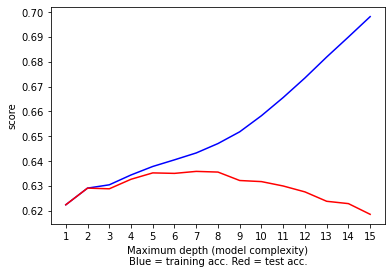

In [18]:
import matplotlib.pyplot as plt
result_set['params']
dd = pd.DataFrame(result_set['params'])

train_result = result_set['mean_train_score']
test_result = result_set['mean_test_score']

max_depth_train = []
max_depth_test = []
index_ = list(dd.index[(dd['criterion']=='entropy') & (dd['min_samples_leaf']==10)])
for i in range(len(index_)):
    max_depth_train.append(train_result[index_[i]])
    max_depth_test.append(test_result[index_[i]])
plt.plot(range(1, len(max_depth_train)+1), max_depth_train, 'b', range(1,len(max_depth_test)+1), max_depth_test, 'r')
plt.xlabel('Maximum depth (model complexity)\nBlue = training acc. Red = test acc.')
plt.xticks(np.arange(1, len(max_depth_train)+1, 1))
plt.ylabel('score')
plt.show()

In [19]:
cv_1.fit(X_train, y_train)

print("Train accuracy:", cv_1.score(X_train, y_train))
print("Test accuracy:", cv_1.score(X_test, y_test))

Train accuracy: 0.6476432277293299
Test accuracy: 0.6387636831938184


In [20]:
n_nodes = cv_1.tree_.node_count
print("The number of nodes are:")
print(n_nodes)
leaf = cv_1.get_n_leaves()
print("The number of rules are:")
print(leaf)

The number of nodes are:
221
The number of rules are:
111


In [24]:
from dm_tools import analyse_feature_importance, visualize_decision_tree

analyse_feature_importance(cv_1, X.columns, 5)
visualize_decision_tree(cv_1, X.columns, "optimal_tree.png")

number_inpatient : 0.5251164317425324
discharge_disposition_id_11 : 0.12595951186119314
number_emergency : 0.051277435893517485
number_outpatient : 0.04072885376284951
diabetesMed : 0.029781302282978147


In [26]:
dt_cv_best = cv_1
# probability prediction from decision tree
y_pred_proba_dt = dt_cv_best.predict_proba(X_test)


print("Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.")
print("(Probs on zero)\t(probs on one)\t(prediction made)")
# print top 10
for i in range(20):
    print(y_pred_proba_dt[i][0], '\t', y_pred_proba_dt[i][1], '\t', y_pred[i])

Probability produced by decision tree for each class vs actual prediction on TargetB (0 = non-donor, 1 = donor). You should be able to see the default threshold of 0.5.
(Probs on zero)	(probs on one)	(prediction made)
0.7733598409542743 	 0.22664015904572565 	 0
0.5971223021582733 	 0.4028776978417266 	 0
0.5446428571428571 	 0.45535714285714285 	 1
0.2759433962264151 	 0.7240566037735849 	 0
0.36658354114713215 	 0.6334164588528678 	 1
0.6447174447174447 	 0.35528255528255526 	 0
0.2759433962264151 	 0.7240566037735849 	 0
0.05 	 0.95 	 1
0.7733598409542743 	 0.22664015904572565 	 0
0.4440124416796267 	 0.5559875583203733 	 1
0.4855570839064649 	 0.5144429160935351 	 0
0.4440124416796267 	 0.5559875583203733 	 1
0.4440124416796267 	 0.5559875583203733 	 0
0.2445759368836292 	 0.7554240631163708 	 0
0.4440124416796267 	 0.5559875583203733 	 1
0.4440124416796267 	 0.5559875583203733 	 0
0.2759433962264151 	 0.7240566037735849 	 0
0.6992771084337349 	 0.3007228915662651 	 0
0.44401244167

In [27]:
from sklearn.metrics import roc_auc_score

y_pred_proba_dt = model.predict_proba(X_test)
y_pred_proba_dt_cv = dt_cv_best.predict_proba(X_test)

roc_index_dt = roc_auc_score(y_test, y_pred_proba_dt[:, 1])
roc_index_dt_cv = roc_auc_score(y_test, y_pred_proba_dt_cv[:, 1])

print("ROC index on test for DT_default:", roc_index_dt)
print("ROC index on test for DT_optimal:", roc_index_dt_cv)

ROC index on test for DT_default: 0.5690761587471861
ROC index on test for DT_optimal: 0.6774909097184696


In [31]:
from sklearn.metrics import roc_curve

fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt[:,1])
fpr_dt_cv, tpr_dt_cv, thresholds_dt_cv = roc_curve(y_test, y_pred_proba_dt_cv[:,1])

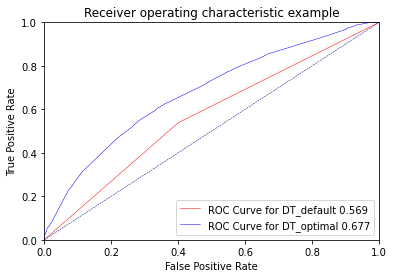

In [30]:
import matplotlib.pyplot as plt

plt.plot(fpr_dt, tpr_dt, label='ROC Curve for DT_default {:.3f}'.format(roc_index_dt), color='red', lw=0.5)
plt.plot(fpr_dt_cv, tpr_dt_cv, label='ROC Curve for DT_optimal {:.3f}'.format(roc_index_dt_cv), color='blue', lw=0.5)


plt.plot([0, 1], [0, 1], color='navy', lw=0.5, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import pickle
dt_best = cv_1
with open('DT.pickle', 'wb') as f:
    pickle.dump([dt_best,roc_index_dt_cv, fpr_dt_cv, tpr_dt_cv], f)